In [232]:
import sklearn 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [153]:
# Walk : Category 1
# Run : Category 2
# Climb : Category 3
# Travel : Category 4
# Sit : Category 5
walk = pd.read_csv('walk.csv')
run = pd.read_csv('run.csv')
climb = pd.read_csv('stair.csv')
travel = pd.read_csv('travel.csv')
sit = pd.read_csv('browse.csv')

In [159]:
sit

,time,gFx,gFy,gFz,TgF
0,0.005,0.2337,-0.3494,1.0940,0.994
1,0.006,0.2307,-0.3470,1.1079,1.007
2,0.006,0.2295,-0.3474,1.1067,1.006
3,0.006,0.2261,-0.3467,1.1040,1.003
4,0.007,0.2188,-0.3504,1.0986,0.996
...,...,...,...,...,...
126130,306.475,0.2141,-0.3401,1.0579,0.957
126131,306.477,0.2139,-0.3421,1.0623,0.961
126132,306.480,0.2171,-0.3431,1.0696,0.968
126133,306.482,0.2197,-0.3465,1.0779,0.976


In [353]:
def conv_100hz(df):
    return df.groupby(np.arange(len(df))//4).mean()
def features(df):
    df = df[df['time']<=300.01]
    df_mean= df.groupby(np.arange(len(df))//1000).mean()
    df_std= df.groupby(np.arange(len(df))//1000).std()
    df_skew= df.groupby(np.arange(len(df))//1000).skew()
    df_1q= df.groupby(np.arange(len(df))//1000).mean(0.25)
    df_2q= df.groupby(np.arange(len(df))//1000).mean(0.5)
    df_3q= df.groupby(np.arange(len(df))//1000).quantile(0.75)
    df_mean.rename(columns={'gFx':'x_mean',
                           'gFy':'y_mean',
                           'gFz':'z_mean'},inplace=True)
    df_std.rename(columns={'gFx':'x_std',
                           'gFy':'y_std',
                           'gFz':'z_std'},inplace=True)
    df_skew.rename(columns={'gFx':'x_skew',
                           'gFy':'y_skew',
                           'gFz':'z_skew'},inplace=True)
    df_feat = pd.concat([df_mean[['x_mean','y_mean','z_mean']],
                        df_std[['x_std','y_std','z_std']],
                        df_skew[['x_skew','y_skew','z_skew']]],axis=1)
    df_train = df_feat.loc[:24]
    df_test = df_feat.loc[25:]
    return df_feat,df_train,df_test
def plotting(df,name):
    df = df[df['time']<=240.01]
    df= df.groupby(np.arange(len(df))//1000).mean()
    plt.plot(df['time'],df['gFx'],'r')
    plt.plot(df['time'],df['gFy'],'b')
    plt.plot(df['time'],df['gFz'],'k')
    labels=['gFx','gFy','gFz']
    plt.legend(labels,loc=0)
    plt.title('X,Y,Z accelerometer data for {}'.format(name))
    plt.xlabel('time(s)')
    plt.ylabel('accl data (m/s2)')

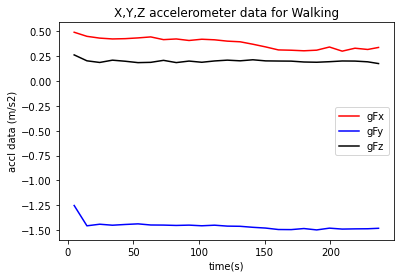

In [354]:
plotting(conv_100hz(walk),'Walking')

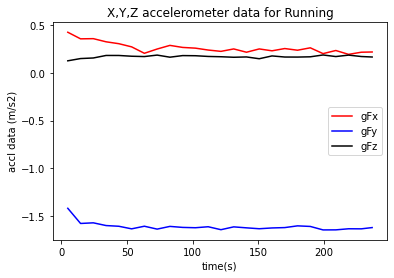

In [355]:
plotting(conv_100hz(run),'Running')

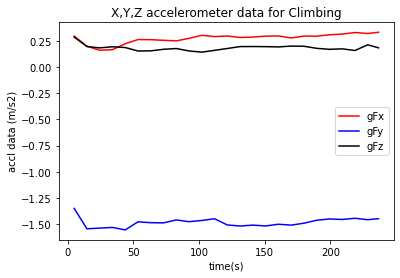

In [356]:
plotting(conv_100hz(climb),'Climbing')

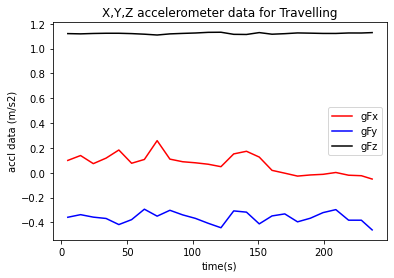

In [357]:
plotting(conv_100hz(travel),'Travelling')

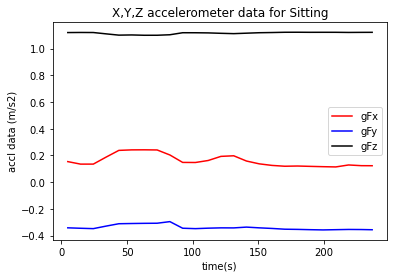

In [358]:
plotting(conv_100hz(sit),'Sitting')

In [359]:
walk_feat,walk_train,walk_test = features(conv_100hz(walk))
run_feat,run_train,run_test = features(conv_100hz(run))
climb_feat,climb_train,climb_test = features(conv_100hz(climb))
travel_feat,travel_train,travel_test = features(conv_100hz(travel))
sit_feat,sit_train,sit_test = features(conv_100hz(sit))

### Training feature set for walking

In [360]:
walk_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_skew,y_skew,z_skew
0,0.491517,-1.252861,0.263467,0.390975,0.457152,0.438977,0.544203,0.382532,-0.024516
1,0.450346,-1.457456,0.203852,0.487275,0.404342,0.388561,1.593854,-0.885087,-1.835580
2,0.432458,-1.441411,0.187318,0.477427,0.471373,0.364918,1.593651,-0.737450,-2.000419
3,0.423997,-1.451394,0.210342,0.469983,0.418338,0.321359,1.486691,-0.827095,-0.965075
4,0.426911,-1.443967,0.199539,0.429864,0.375754,0.335643,1.280175,-0.786630,-0.536857
5,0.434468,-1.437754,0.185624,0.389456,0.329148,0.296961,0.890414,-0.776662,-1.160230
6,0.444469,-1.449269,0.188448,0.452005,0.400026,0.352744,1.351893,-0.747634,-1.045901
7,0.417030,-1.450144,0.208512,0.458419,0.448713,0.363170,1.241559,-0.798522,-0.950994
8,0.423944,-1.453680,0.185986,0.452235,0.427146,0.357602,1.793540,-0.777678,-1.218278
9,0.408546,-1.450512,0.201278,0.445744,0.407908,0.342766,1.560601,-0.873024,-1.491395


### Testing feature set for walking

In [362]:
walk_test

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_skew,y_skew,z_skew
25,0.342027,-1.483135,0.208365,0.461271,0.424144,0.381240,1.407244,-0.644032,-0.756464
26,0.334798,-1.487923,0.191135,0.440400,0.438567,0.347761,1.573577,-0.867563,-1.624050
27,0.336747,-1.484883,0.199309,0.446504,0.414292,0.418026,1.618430,-0.907271,-1.427849
28,0.324994,-1.485308,0.214672,0.456312,0.455343,0.417618,1.544048,-1.055511,-2.014813
29,0.334305,-1.492998,0.191224,0.440917,0.399572,0.359692,1.337828,-0.814000,-0.988776
30,0.326529,-1.481905,0.176522,0.457325,0.419571,0.407981,1.433822,-0.845914,-1.285395


In [165]:
comb_train= np.vstack((walk_train,run_train,climb_train,travel_train,sit_train))
comb_test= np.vstack((walk_test,run_test,climb_test,travel_test,sit_test))

In [228]:
comb_test

array([[ 3.42026875e-01, -1.48313507e+00,  2.08364550e-01,
         4.61271055e-01,  4.24144326e-01,  3.81240454e-01,
         1.40724377e+00, -6.44032405e-01, -7.56464469e-01],
       [ 3.34797775e-01, -1.48792302e+00,  1.91134950e-01,
         4.40399697e-01,  4.38567123e-01,  3.47761079e-01,
         1.57357674e+00, -8.67562985e-01, -1.62404955e+00],
       [ 3.36747350e-01, -1.48488340e+00,  1.99309500e-01,
         4.46503739e-01,  4.14292495e-01,  4.18025761e-01,
         1.61843047e+00, -9.07271310e-01, -1.42784941e+00],
       [ 3.24994350e-01, -1.48530770e+00,  2.14671550e-01,
         4.56312005e-01,  4.55342791e-01,  4.17618132e-01,
         1.54404816e+00, -1.05551093e+00, -2.01481280e+00],
       [ 3.34304625e-01, -1.49299818e+00,  1.91224050e-01,
         4.40916640e-01,  3.99572354e-01,  3.59691925e-01,
         1.33782845e+00, -8.14000454e-01, -9.88775528e-01],
       [ 3.26529162e-01, -1.48190477e+00,  1.76522023e-01,
         4.57324688e-01,  4.19571108e-01,  4.079814

In [233]:
category= np.vstack((np.ones((1,25)).T,
          2*np.ones((1,25)).T,
           3*np.ones((1,25)).T,
           4*np.ones((1,25)).T,
           5*np.ones((1,25)).T
          ))
category_score= np.vstack((np.ones((1,6)).T,
          2*np.ones((1,6)).T,
           3*np.ones((1,6)).T,
           4*np.ones((1,6)).T,
           5*np.ones((1,6)).T
          ))

In [234]:
category.shape

(125, 1)

### Decision Tree training and prediction

In [187]:
clf = tree.DecisionTreeClassifier()
clf.fit(comb_train,category)

DecisionTreeClassifier()

In [190]:
clf.predict(comb_test)

array([1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.,
       3., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.])

### SVM training and prediciton

In [194]:
clf_svm=make_pipeline(StandardScaler(),SVC(gamma='auto'))
clf_svm.fit(comb_train,category)

C:\Users\vshas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [195]:
clf_svm.predict(comb_test)

array([1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.,
       3., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.])

### K nearest neighbors training and prediction

In [203]:
clf_knn= KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(comb_train,category)

C:\Users\vshas\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [204]:
clf_knn.predict(comb_test)

array([1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.,
       2., 5., 5., 5., 4., 5., 4., 4., 5., 5., 5., 4., 4.])

### Logistic regression training and prediciton

In [206]:
clf_log = LogisticRegression(random_state=0).fit(comb_train,category)

C:\Users\vshas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [207]:
clf_log.predict(comb_test)

array([1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.,
       2., 4., 4., 4., 4., 4., 4., 4., 5., 1., 5., 4., 4.])

### Logistic regression accuracy

In [224]:
clf_log.score(comb_test,category_score)

0.8333333333333334

### K nearest neigbors accuracy

In [229]:
clf_knn.score(comb_test,category_score)

0.7333333333333333

### SVM accuracy

In [230]:
clf_svm.score(comb_test,category_score)

1.0

### Decision Tree classifier accuracy

In [231]:
clf.score(comb_test,category_score)

1.0

### Notes:

My features for training my classifiers are mean, standard deviation and skewness of accelerometer data for each x,y,z axes. 
Thus my feature vectors have are of size 25x9. 

Note that for the features that I've trained, the best accuracy I've gotten was 100% (i.e. I've correctly classified the test data). This was for both the SVM and the Decision tree.

For the other classification algorithms, I've gotten 73% for knn, and 83% for logistic regression. 

Mainly, I've found the first two categories (walking and running) to be correctly classified. But the inaccuracy starts in the categories: climbing, travelling and sitting (browsing). 

I've found out that travelling and browsing were hard to discern for knn and logistic regression and some feature vectors were misclassified and mixed up. This could be due to being in a seating position in both activities, the difference being subtle jerks and motions in travelling. 



